/Users/samsonkoelle/manifoldflasso_jmlr
preembed November_05_2020_14_24_17


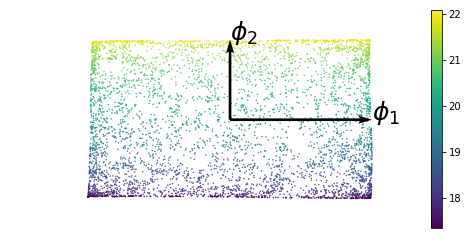

In [1]:
import matplotlib
matplotlib.use('Agg')
import os
import matplotlib.pyplot as plt
import datetime
import numpy as np
import dill as pickle
import random
from shutil import copyfile
import sys
import copy
np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = '/Users/samsonkoelle/manifoldflasso_jmlr'
#workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)
#print(os.getcwd())
#from codes.experimentclasses.SwissRoll49 import SwissRoll49


from codes.flasso.FlassoManifold import FlassoManifold
from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.otherfunctions.data_stream import data_stream
from codes.geometer.ShapeSpace import compute3angles
import numpy as np
from scipy.stats import special_ortho_group
import math
from pathos.multiprocessing import ProcessingPool as Pool

# def rotator(rotatee, theta):
#     rm = np.asarray([[np.cos(theta), - np.sin(theta)],[np.sin(theta), np.cos(theta)]])
#     rm2 = np.zeros((49,49))
#     for i in range(24):
#         rm2[(2*i):(2*(i+1)),(2*i):(2*(i+1))] = rm
#     rm2[48,48] = 1.
#     output = np.matmul(rm2, rotatee.transpose())
#     return(output.transpose())

def get_grad(t):
    output = np.zeros((49,2))
    output[0,0] = ((np.cos(t) - t*np.sin(t)) / (np.sin(t) + t*np.cos(t)))
    output[2,0] = 1.
    output[1,1] = 1.
    output = output / np.linalg.norm(output, axis = 0)
    return(output)

def dup_cols(a, indx, num_dups=1):
    return np.insert(a,[indx+1]*num_dups,a[:,[indx]],axis=1)

class SwissRoll49(FlassoManifold):
    """
    Parameters
    ----------
    cor : string,
        Data file to load
    xvar : np.array(dtype = int),
        List of adjacencies
    jj : np.array,
        List of adjacencies part 2
    d : int,
        dimension over which to evaluate the radii (smaller usually better)
    rmin : float,
        smallest radius ( = rad_bw_ratio * bandwidth) to consider
    rmax : float,
        largest radius ( = rad_bw_ratio * bandwidth) to consider
    ntry : int,
        number of radii between rmax and rmin to try
    run_parallel : bool,
        whether to run the analysis in parallel over radii
    search_space : str,
        either 'linspace' or 'logspace', choose to search in log or linear space
    rad_bw_ratio : float,
        the ratio of radius and kernel bandwidth, default to be 3 (radius = 3*h)
    Methods
    -------
    generate_data :
        Simulates data
    get_atoms_4 :
    	Gets atomic tetrahedra based off of ii and jj
    get_atoms_3 :
    	Gets triples of atoms

    """

    # AtomicRegression(dim, ii, jj, filename)
    def __init__(self,  xvar,cores, noise):
        natoms = 9
        self.xvar = xvar
        self.cores = cores
        self.noise = noise
        self.dim = 2
        self.d = 49
        self.p = 51

    def generate_data(self, n,theta):
        self.n = n
        d = self.d
        xvar = self.xvar
        dim = self.dim
        noise = self.noise
        self.theta = theta
        ts = .75 * np.pi * (1 + 2 * np.random.uniform(low=0.0, high=1.0, size=n)) + 15
        #ts = np.pi * (1 + 2 * np.random.uniform(low=0.0, high=1.0, size=n)) + 15
        #ts = 1.5*np.pi * (1 + 2 * np.random.uniform(low=0.0, high=1.0, size=n)) + 15
        x = ts * np.cos(ts)
        y = 101 * np.random.uniform(low=0.0, high=1.0, size=n)
        self.ys = y
        z = ts * np.sin(ts)
        self.ts = ts
        X = np.vstack((x, y, z))
        #X += noise * generator.randn(3, n_samples)
        X = X.T
        unrotated_data = np.zeros((n,49))
        unrotated_data[:,:3] = X
        rotator = special_ortho_group.rvs(49)
        #rotator = np.identity(49)
        self.rotator = rotator
        data = np.matmul(unrotated_data, rotator)
        if xvar != 0.:
            data += np.random.multivariate_normal(np.zeros(49),np.identity(49)*xvar, n)
        #for i in range(n):
        #    #print(i)
        #    data[i] += np.random.multivariate_normal(np.zeros(49),np.identity(49)*xvar)
        #data = rotator(X,theta)
        #data = dup_cols(data, indx=0, num_dups=46)
        #data = np.reshape(results, (n, (d)))
        return (RiemannianManifold(data, dim))

    def get_dx_g_full(self, data):
        d = self.d
        p = self.p
        #n = data.shape[0]
        n = len(self.selected_points)
        ts = self.ts[self.selected_points]
        grads = np.asarray([get_grad(t) for t in ts])
        rotator = self.rotator
        #grads2 = rotator(grads, theta)
        fullgrads = np.zeros((n, d, p))
        for i in range(n):
            fullgrads[i, :, 0:2] = np.matmul(rotator.transpose(), grads[i])
            fullgrads[i, :, 2:] = np.identity(49)
        output = np.swapaxes(fullgrads,1,2)
        return (output)


    def get_dx_g_full_2(self, selected_points):
        d = self.d
        p = self.p
        #n = data.shape[0]
        n = len(selected_points)
        ts = self.ts[selected_points]
        grads = np.asarray([get_grad(t) for t in ts])
        rotator = self.rotator
        #grads2 = rotator(grads, theta)
        fullgrads = np.zeros((n, d, p))
        for i in range(n):
            #040220 added transpose... then removed
            fullgrads[i, :, 0:2] = np.matmul(rotator.transpose(), grads[i])
            fullgrads[i, :, 2:] = np.identity(49)
        output = np.swapaxes(fullgrads,1,2)
        return (output)
    
from codes.otherfunctions.multirun import get_coeffs_and_lambdas
from codes.otherfunctions.multirun import get_support
from codes.otherfunctions.multiplot import plot_support_2d
from codes.otherfunctions.multiplot import plot_reg_path_ax_lambdasearch
from codes.otherfunctions.multiplot import plot_gs_v_dgnorm
from codes.otherfunctions.multirun import get_cosines
from codes.otherfunctions.multiplot import plot_reg_path_ax_lambdasearch_customcolors
#from codes.otherfunctions.multirun import get_grads_reps_noshape
from codes.otherfunctions.multiplot import plot_betas_customcolors2
from codes.otherfunctions.multirun import get_support_recovery_lambda
from codes.otherfunctions.multirun import get_lower_interesting_lambda
from codes.otherfunctions.multirun import get_grads_noshape_swiss
from codes.flasso.Replicate import Replicate
from megaman.embedding import LTSA
from megaman.embedding import Isomap
import matplotlib.pyplot as plt

def get_betas_spam2(xs, ys, groups, lambdas, n, q, itermax, tol):
    # n = xs.shape[0]
    p = len(np.unique(groups))
    lambdas = np.asarray(lambdas, dtype=np.float64)
    yadd = np.expand_dims(ys, 1)
    groups = np.asarray(groups, dtype=np.int32) + 1
    W0 = np.zeros((xs.shape[1], yadd.shape[1]), dtype=np.float32)
    Xsam = np.asfortranarray(xs, dtype=np.float32)
    Ysam = np.asfortranarray(yadd, dtype=np.float32)
    coeffs = np.zeros((len(lambdas), q, n, p))
    for i in range(len(lambdas)):
        # alpha = spams.fistaFlat(Xsam,Dsam2,alpha0sam,ind_groupsam,lambda1 = lambdas[i],mode = mode,itermax = itermax,tol = tol,numThreads = numThreads, regul = "group-lasso-l2")
        # spams.fistaFlat(Y,X,W0,TRUE,numThreads = 1,verbose = TRUE,lambda1 = 0.05, it0 = 10, max_it = 200,L0 = 0.1, tol = 1e-3, intercept = FALSE,pos = FALSE,compute_gram = TRUE, loss = 'square',regul = 'l1')
        output = spams.fistaFlat(Ysam, Xsam, W0, True, groups=groups, numThreads=-1, verbose=True,
                                     lambda1=lambdas[i], it0=100, max_it=itermax, L0=0.5, tol=tol, intercept=False,
                                     pos=False, compute_gram=True, loss='square', regul='group-lasso-l2', ista=False,
                                     subgrad=False, a=0.1, b=1000)
        coeffs[i, :, :, :] = np.reshape(output[0], (q, n, p))
        # print(output[1])
    return (coeffs)

def get_coeffs(experiment, lambdas, itermax, nsel, tol):
    experiment.xtrain, experiment.groups = experiment.construct_X_js(experiment.dg_M)
    experiment.ytrain = experiment.construct_Y_js(experiment.df_M)
    experiment.coeffs = get_betas_spam2(experiment.xtrain, experiment.ytrain, experiment.groups, lambdas,
                                        nsel, experiment.q, itermax, tol)
    return (experiment)

def get_coeffs_parallel(experiments, nreps, lambdas, itermax, nsel, tol, cores):
    p = Pool(cores)
    results = p.map(
        lambda i: get_coeffs(experiment=experiments[i], lambdas=lambdas, itermax=itermax, nsel=nsel, tol=tol),
        range(nreps))
    output = {}
    for i in range(nreps):
        output[i] = results[i]
    return (output)

from pathos.multiprocessing import ProcessingPool as Pool
import spams

#set parameters
n = 5000 #number of data points to simulate
nsel = 5 #number of points to analyze with lasso
itermax = 1000 #maximum iterations per lasso run
tol = 1e-10 #convergence criteria for lasso
#lambdas = np.asarray([5,10,15,20,25,50,75,100], dtype = np.float16)#lambda values for lasso
#lambdas = np.asarray([0,2.95339658e-06, 5.90679317e-06, 8.86018975e-06, 1.18135863e-05,
#       1.47669829e-05, 2.95339658e-05, 4.43009487e-05, 5.90679317e-05])
lambdas = np.asarray([0,.1,1,10,100], dtype = np.float64)
n_neighbors = 1000 #number of neighbors in megaman
n_components = 2 #number of embedding dimensions (diffusion maps)
#10000 points and .17 dt is best so far
#100000 and .05 is better
#thats with 50 neighbors
#diffusion_time = 0.05 #diffusion time controls gaussian kernel radius per gradients paper
#diffusion_time = 0.1
#diffusion_time = 0.25
diffusion_time = 1.
nreps = 2
m = 2
dimnoise = 2
dim = 2 #manifold dimension
cores = 16 #number of cores for parallel processing
p = 51
lambda_max = 1
max_search = 30

folder = workingdirectory + '/Figures/swissroll/' + now + 'n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(nreps)
os.mkdir(folder)
#src = workingdirectory + '/codes/experiments/swissroll_multi_moredim_040220.py'
#filenamescript = folder + '/script.py'
#copyfile(src, filenamescript)

new_MN = True
savename = 'swissroll_041420_5k'
savefolder = 'swissroll'
loadfolder = 'swissroll'
loadname = 'swissroll_041420_5k'
if new_MN == True:
    experiment = SwissRoll49(xvar = 0.0,cores = cores, noise = False)
    experiment.M = experiment.generate_data(n=n,theta=np.pi / 4)  # if noise == False then noise parameters are overriden
    experiment.q = n_components
    experiment.M.geom = experiment.M.compute_geom(diffusion_time, n_neighbors)
    print('preembed', datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S"))
    experiment.N = experiment.M.get_embedding3(experiment.M.geom, n_components, diffusion_time, dim)

#     with open(workingdirectory + '/untracked_data/embeddings/' + savefolder + '/' + savename + '.pkl' ,
#              'wb') as output:
#          pickle.dump(experiment, output, pickle.HIGHEST_PROTOCOL)
# else:
#     file = open(workingdirectory + '/untracked_data/embeddings/' + savefolder + '/' + savename + '.pkl', 'rb')
#     experiment = pickle.load(file)
#     file.close()


%matplotlib inline
experiment.N.plot([0,1], list(range(n)), experiment.ts, 1,1,folder + '/internal_1_xxx')

/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  


preembed November_05_2020_14_24_25


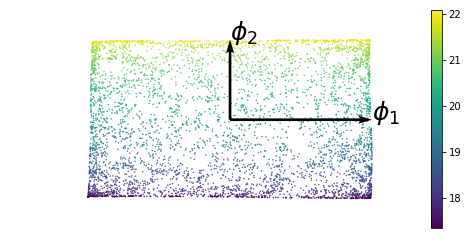

In [2]:
import matplotlib
matplotlib.use('Agg')
import os
import matplotlib.pyplot as plt
import datetime
import numpy as np
import dill as pickle
import random
from shutil import copyfile
import sys
import copy
np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = '/Users/samsonkoelle/manifoldflasso_jmlr'
#workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)
#print(os.getcwd())
#from codes.experimentclasses.SwissRoll49 import SwissRoll49


from codes.flasso.FlassoManifold import FlassoManifold
from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.otherfunctions.data_stream import data_stream
from codes.geometer.ShapeSpace import compute3angles
import numpy as np
from scipy.stats import special_ortho_group
import math
from pathos.multiprocessing import ProcessingPool as Pool

# def rotator(rotatee, theta):
#     rm = np.asarray([[np.cos(theta), - np.sin(theta)],[np.sin(theta), np.cos(theta)]])
#     rm2 = np.zeros((49,49))
#     for i in range(24):
#         rm2[(2*i):(2*(i+1)),(2*i):(2*(i+1))] = rm
#     rm2[48,48] = 1.
#     output = np.matmul(rm2, rotatee.transpose())
#     return(output.transpose())

def get_grad(t):
    output = np.zeros((49,2))
    output[0,0] = ((np.cos(t) - t*np.sin(t)) / (np.sin(t) + t*np.cos(t)))
    output[2,0] = 1.
    output[1,1] = 1.
    output = output / np.linalg.norm(output, axis = 0)
    return(output)

def dup_cols(a, indx, num_dups=1):
    return np.insert(a,[indx+1]*num_dups,a[:,[indx]],axis=1)

class SwissRoll49(FlassoManifold):
    """
    Parameters
    ----------
    cor : string,
        Data file to load
    xvar : np.array(dtype = int),
        List of adjacencies
    jj : np.array,
        List of adjacencies part 2
    d : int,
        dimension over which to evaluate the radii (smaller usually better)
    rmin : float,
        smallest radius ( = rad_bw_ratio * bandwidth) to consider
    rmax : float,
        largest radius ( = rad_bw_ratio * bandwidth) to consider
    ntry : int,
        number of radii between rmax and rmin to try
    run_parallel : bool,
        whether to run the analysis in parallel over radii
    search_space : str,
        either 'linspace' or 'logspace', choose to search in log or linear space
    rad_bw_ratio : float,
        the ratio of radius and kernel bandwidth, default to be 3 (radius = 3*h)
    Methods
    -------
    generate_data :
        Simulates data
    get_atoms_4 :
    	Gets atomic tetrahedra based off of ii and jj
    get_atoms_3 :
    	Gets triples of atoms

    """

    # AtomicRegression(dim, ii, jj, filename)
    def __init__(self,  xvar,cores, noise):
        natoms = 9
        self.xvar = xvar
        self.cores = cores
        self.noise = noise
        self.dim = 2
        self.d = 49
        self.p = 51

    def generate_data(self, n,theta):
        self.n = n
        d = self.d
        xvar = self.xvar
        dim = self.dim
        noise = self.noise
        self.theta = theta
        ts = .75 * np.pi * (1 + 2 * np.random.uniform(low=0.0, high=1.0, size=n)) + 15
        #ts = np.pi * (1 + 2 * np.random.uniform(low=0.0, high=1.0, size=n)) + 15
        #ts = 1.5*np.pi * (1 + 2 * np.random.uniform(low=0.0, high=1.0, size=n)) + 15
        x = ts * np.cos(ts)
        y = 101 * np.random.uniform(low=0.0, high=1.0, size=n)
        self.ys = y
        z = ts * np.sin(ts)
        self.ts = ts
        X = np.vstack((x, y, z))
        #X += noise * generator.randn(3, n_samples)
        X = X.T
        unrotated_data = np.zeros((n,49))
        unrotated_data[:,:3] = X
        rotator = special_ortho_group.rvs(49)
        #rotator = np.identity(49)
        self.rotator = rotator
        data = np.matmul(unrotated_data, rotator)
        if xvar != 0.:
            data += np.random.multivariate_normal(np.zeros(49),np.identity(49)*xvar, n)
        #for i in range(n):
        #    #print(i)
        #    data[i] += np.random.multivariate_normal(np.zeros(49),np.identity(49)*xvar)
        #data = rotator(X,theta)
        #data = dup_cols(data, indx=0, num_dups=46)
        #data = np.reshape(results, (n, (d)))
        return (RiemannianManifold(data, dim))

    def get_dx_g_full(self, data):
        d = self.d
        p = self.p
        #n = data.shape[0]
        n = len(self.selected_points)
        ts = self.ts[self.selected_points]
        grads = np.asarray([get_grad(t) for t in ts])
        rotator = self.rotator
        #grads2 = rotator(grads, theta)
        fullgrads = np.zeros((n, d, p))
        for i in range(n):
            fullgrads[i, :, 0:2] = np.matmul(rotator.transpose(), grads[i])
            fullgrads[i, :, 2:] = np.identity(49)
        output = np.swapaxes(fullgrads,1,2)
        return (output)


    def get_dx_g_full_2(self, selected_points):
        d = self.d
        p = self.p
        #n = data.shape[0]
        n = len(selected_points)
        ts = self.ts[selected_points]
        grads = np.asarray([get_grad(t) for t in ts])
        rotator = self.rotator
        #grads2 = rotator(grads, theta)
        fullgrads = np.zeros((n, d, p))
        for i in range(n):
            #040220 added transpose... then removed
            fullgrads[i, :, 0:2] = np.matmul(rotator.transpose(), grads[i])
            fullgrads[i, :, 2:] = np.identity(49)
        output = np.swapaxes(fullgrads,1,2)
        return (output)
    
from codes.otherfunctions.multirun import get_coeffs_and_lambdas
from codes.otherfunctions.multirun import get_support
from codes.otherfunctions.multiplot import plot_support_2d
from codes.otherfunctions.multiplot import plot_reg_path_ax_lambdasearch
from codes.otherfunctions.multiplot import plot_gs_v_dgnorm
from codes.otherfunctions.multirun import get_cosines
from codes.otherfunctions.multiplot import plot_reg_path_ax_lambdasearch_customcolors
#from codes.otherfunctions.multirun import get_grads_reps_noshape
from codes.otherfunctions.multiplot import plot_betas_customcolors2
from codes.otherfunctions.multirun import get_support_recovery_lambda
from codes.otherfunctions.multirun import get_lower_interesting_lambda
from codes.otherfunctions.multirun import get_grads_noshape_swiss
from codes.flasso.Replicate import Replicate
from megaman.embedding import LTSA
from megaman.embedding import Isomap
import matplotlib.pyplot as plt

def get_betas_spam2(xs, ys, groups, lambdas, n, q, itermax, tol):
    # n = xs.shape[0]
    p = len(np.unique(groups))
    lambdas = np.asarray(lambdas, dtype=np.float64)
    yadd = np.expand_dims(ys, 1)
    groups = np.asarray(groups, dtype=np.int32) + 1
    W0 = np.zeros((xs.shape[1], yadd.shape[1]), dtype=np.float32)
    Xsam = np.asfortranarray(xs, dtype=np.float32)
    Ysam = np.asfortranarray(yadd, dtype=np.float32)
    coeffs = np.zeros((len(lambdas), q, n, p))
    for i in range(len(lambdas)):
        # alpha = spams.fistaFlat(Xsam,Dsam2,alpha0sam,ind_groupsam,lambda1 = lambdas[i],mode = mode,itermax = itermax,tol = tol,numThreads = numThreads, regul = "group-lasso-l2")
        # spams.fistaFlat(Y,X,W0,TRUE,numThreads = 1,verbose = TRUE,lambda1 = 0.05, it0 = 10, max_it = 200,L0 = 0.1, tol = 1e-3, intercept = FALSE,pos = FALSE,compute_gram = TRUE, loss = 'square',regul = 'l1')
        output = spams.fistaFlat(Ysam, Xsam, W0, True, groups=groups, numThreads=-1, verbose=True,
                                     lambda1=lambdas[i], it0=100, max_it=itermax, L0=0.5, tol=tol, intercept=False,
                                     pos=False, compute_gram=True, loss='square', regul='group-lasso-l2', ista=False,
                                     subgrad=False, a=0.1, b=1000)
        coeffs[i, :, :, :] = np.reshape(output[0], (q, n, p))
        # print(output[1])
    return (coeffs)

def get_coeffs(experiment, lambdas, itermax, nsel, tol):
    experiment.xtrain, experiment.groups = experiment.construct_X_js(experiment.dg_M)
    experiment.ytrain = experiment.construct_Y_js(experiment.df_M)
    experiment.coeffs = get_betas_spam2(experiment.xtrain, experiment.ytrain, experiment.groups, lambdas,
                                        nsel, experiment.q, itermax, tol)
    return (experiment)

def get_coeffs_parallel(experiments, nreps, lambdas, itermax, nsel, tol, cores):
    p = Pool(cores)
    results = p.map(
        lambda i: get_coeffs(experiment=experiments[i], lambdas=lambdas, itermax=itermax, nsel=nsel, tol=tol),
        range(nreps))
    output = {}
    for i in range(nreps):
        output[i] = results[i]
    return (output)

from pathos.multiprocessing import ProcessingPool as Pool
import spams

#set parameters
n = 5000 #number of data points to simulate
nsel = 5 #number of points to analyze with lasso
itermax = 1000 #maximum iterations per lasso run
tol = 1e-10 #convergence criteria for lasso
#lambdas = np.asarray([5,10,15,20,25,50,75,100], dtype = np.float16)#lambda values for lasso
#lambdas = np.asarray([0,2.95339658e-06, 5.90679317e-06, 8.86018975e-06, 1.18135863e-05,
#       1.47669829e-05, 2.95339658e-05, 4.43009487e-05, 5.90679317e-05])
lambdas = np.asarray([0,.1,1,10,100], dtype = np.float64)
n_neighbors = 1000 #number of neighbors in megaman
n_components = 2 #number of embedding dimensions (diffusion maps)
#10000 points and .17 dt is best so far
#100000 and .05 is better
#thats with 50 neighbors
#diffusion_time = 0.05 #diffusion time controls gaussian kernel radius per gradients paper
#diffusion_time = 0.1
#diffusion_time = 0.25
diffusion_time = 1.
nreps = 2
m = 2
dimnoise = 2
dim = 2 #manifold dimension
cores = 16 #number of cores for parallel processing
p = 51
lambda_max = 1
max_search = 30

folder = workingdirectory + '/Figures/swissroll/' + now + 'n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(nreps)
os.mkdir(folder)
#src = workingdirectory + '/codes/experiments/swissroll_multi_moredim_040220.py'
#filenamescript = folder + '/script.py'
#copyfile(src, filenamescript)

new_MN = True
savename = 'swissroll_041420_5k'
savefolder = 'swissroll'
loadfolder = 'swissroll'
loadname = 'swissroll_041420_5k'
if new_MN == True:
    experiment = SwissRoll49(xvar = 0.0,cores = cores, noise = False)
    experiment.M = experiment.generate_data(n=n,theta=np.pi / 4)  # if noise == False then noise parameters are overriden
    experiment.q = n_components
    experiment.M.geom = experiment.M.compute_geom(diffusion_time, n_neighbors)
    print('preembed', datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S"))
    experiment.N = experiment.M.get_embedding3(experiment.M.geom, n_components, diffusion_time, dim)

#     with open(workingdirectory + '/untracked_data/embeddings/' + savefolder + '/' + savename + '.pkl' ,
#              'wb') as output:
#          pickle.dump(experiment, output, pickle.HIGHEST_PROTOCOL)
# else:
#     file = open(workingdirectory + '/untracked_data/embeddings/' + savefolder + '/' + savename + '.pkl', 'rb')
#     experiment = pickle.load(file)
#     file.close()

%matplotlib inline
experiment.N.plot([0,1], list(range(n)), experiment.ts, 1,1,folder + '/internal_1_xxx')

In [3]:
from codes.geometer.RiemannianManifold import RiemannianManifold
from megaman.geometry import RiemannMetric
N_internal = RiemannianManifold(np.asarray([experiment.ts ,experiment.ys]).transpose(),2)
d = dim
geom = experiment.M.geom
geom.rmetric = RiemannMetric(N_internal.data,experiment.M.geom.laplacian_matrix,n_dim=d)
geom.rmetric.get_rmetric()
N_internal.geom = geom
#df_M,dg_M,dg_x ,dgx_norm  = get_grads_noshape_swiss(experiment, experiment.M, N2, selected_points)

selected_points_save = np.zeros((nreps,nsel))
experiment.p = p
experiment.itermax = itermax
experiment.tol = tol
experiment.dnoise = dim
experiment.nreps = nreps
experiment.nsel = nsel
experiment.dimnoise = dimnoise
experiment.m = m
replicates = {}
selected_points_save = np.zeros((nreps,nsel), dtype = int)
for i in range(nreps):
    selected_points = np.random.choice(list(range(n)),nsel,replace = False)
    selected_points_save[i] = selected_points
    replicates[i] = Replicate()
    replicates[i].nsel = nsel
    replicates[i].selected_points = selected_points
    replicates[i].df_M,replicates[i].dg_M,replicates[i].dg_x ,replicates[i].dgx_norm  = get_grads_noshape_swiss(experiment, experiment.M, N_internal, selected_points)
    replicates[i].xtrain, replicates[i].groups = experiment.construct_X_js(replicates[i].dg_M)
    replicates[i].ytrain = experiment.construct_Y_js(replicates[i].df_M,dimnoise)
    replicates[i].coeff_dict = {}
    replicates[i].coeff_dict[0] = experiment.get_betas_spam2(replicates[i].xtrain, replicates[i].ytrain, replicates[i].groups, np.asarray([0]), nsel, experiment.m, itermax, tol)
    replicates[i].combined_norms = {}
    replicates[i].combined_norms[0] = np.linalg.norm(np.linalg.norm(replicates[i].coeff_dict[0][:, :, :, :], axis=2), axis=1)[0,:]
    replicates[i].higher_lambda,replicates[i].coeff_dict,replicates[i].combined_norms = get_support_recovery_lambda(experiment, replicates[i],  lambda_max, max_search,dim)
    replicates[i].lower_lambda,replicates[i].coeff_dict,replicates[i].combined_norms = get_lower_interesting_lambda(experiment, replicates[i],  lambda_max, max_search)
    #= experiment.get_betas_spam2(replicates[i].xtrain, replicates[i].ytrain, replicates[i].groups, lambdas, len(selected_points), n_embedding_coordinates, itermax, tol)



0 1
1 0.5
2 0.25
we did it
0 1
1 0.5
2 0.25
3 0.125
4 0.0625
5 0.03125
6 0.015625
7 0.0078125
8 0.00390625
9 0.001953125
10 0.0009765625
11 0.00048828125
12 0.000244140625
13 0.0001220703125
14 6.103515625e-05
15 3.0517578125e-05
16 1.52587890625e-05
17 7.62939453125e-06
18 3.814697265625e-06
19 1.9073486328125e-06
20 9.5367431640625e-07
21 4.76837158203125e-07
22 2.384185791015625e-07
23 1.1920928955078125e-07
24 5.960464477539063e-08
25 2.9802322387695312e-08
we did it
0 1
1 0.5
2 0.25
we did it
0 1
1 0.5
2 0.25
3 0.125
4 0.0625
5 0.03125
6 0.015625
7 0.0078125
8 0.00390625
9 0.001953125
10 0.0009765625
11 0.00048828125
12 0.000244140625
13 0.0001220703125
14 6.103515625e-05
15 3.0517578125e-05
16 1.52587890625e-05
17 7.62939453125e-06
18 3.814697265625e-06
19 1.9073486328125e-06
20 9.5367431640625e-07
21 4.76837158203125e-07
22 2.384185791015625e-07
23 1.1920928955078125e-07
24 5.960464477539063e-08
25 2.9802322387695312e-08
we did it


(24,)
(24,)


/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


4

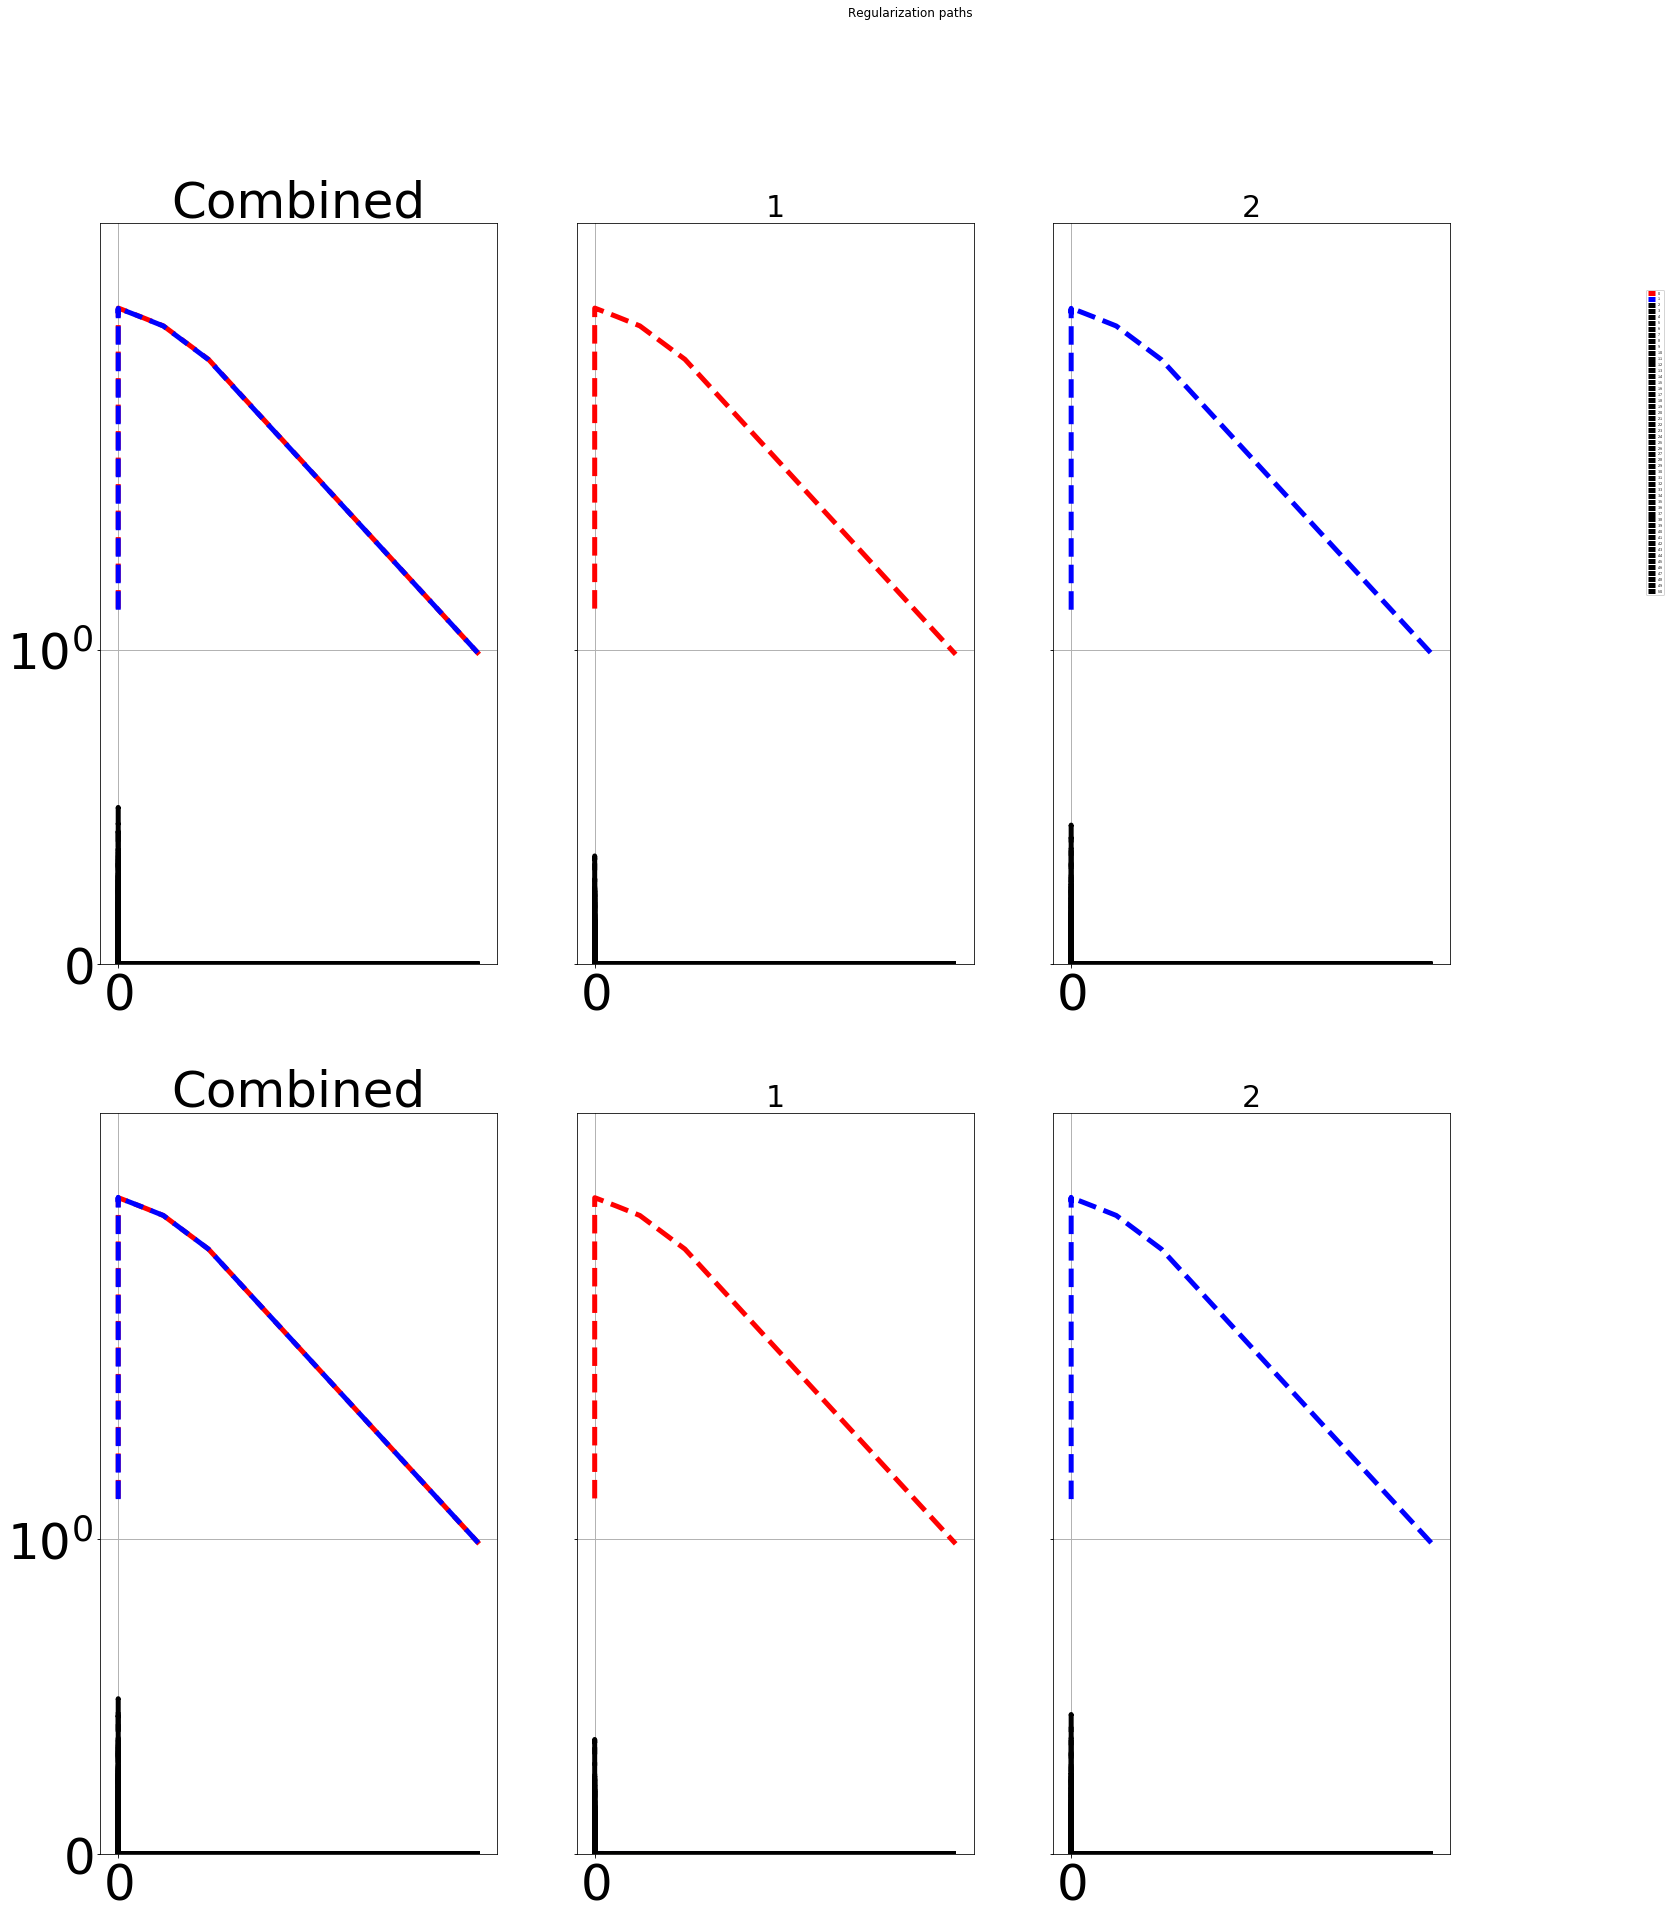

In [4]:
colors = np.hstack([np.repeat('red',1), np.repeat('blue',1),np.repeat('black',49)])

fig, axes_all = plt.subplots(nreps, m + 1,figsize=(15 * m, 15*nreps))
fig.suptitle('Regularization paths')
for i in range(nreps):
    replicates[i].coeffs, replicates[i].lambdas_plot = get_coeffs_and_lambdas(replicates[i].coeff_dict, replicates[i].lower_lambda, replicates[i].higher_lambda)
    plot_reg_path_ax_lambdasearch_customcolors(axes_all[i], replicates[i].coeffs, replicates[i].lambdas_plot * np.sqrt(m * nsel), fig,colors)
fig.savefig(folder + '/swiss_internal')
2+2

In [5]:
replicates_internal = copy.deepcopy(replicates)

In [6]:
isomap = Isomap(n_components=n_components, eigen_solver='arpack',geom=experiment.M.geom)
embed_isomap = isomap.fit_transform(experiment.M.data)

/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/sklearn/utils/validation.py:457: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)


In [25]:
n_components = m
ltsa = LTSA(n_components=n_components,eigen_solver='arpack',geom=experiment.M.geom)
embed_ltsa = ltsa.fit_transform(experiment.M.data)
N_ltsa = RiemannianManifold(embed_ltsa,2)
geom_ltsa = experiment.M.geom
geom_ltsa.rmetric = RiemannMetric(N_ltsa.data,experiment.M.geom.laplacian_matrix,n_dim=d)
geom_ltsa.rmetric.get_rmetric()
N_ltsa.geom = geom_ltsa

/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/sklearn/utils/validation.py:457: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)


KeyboardInterrupt: 

In [26]:
N_ltsa

In [27]:
replicates = {}
for i in range(nreps):
    selected_points = selected_points_save[i]
    replicates[i] = Replicate()
    replicates[i].nsel = nsel
    replicates[i].selected_points = selected_points
    replicates[i].df_M,replicates[i].dg_M,replicates[i].dg_x ,replicates[i].dgx_norm  = get_grads_noshape_swiss(experiment, experiment.M, N_ltsa, selected_points)
    replicates[i].xtrain, replicates[i].groups = experiment.construct_X_js(replicates[i].dg_M)
    replicates[i].ytrain = experiment.construct_Y_js(replicates[i].df_M,dimnoise)
    replicates[i].coeff_dict = {}
    replicates[i].coeff_dict[0] = experiment.get_betas_spam2(replicates[i].xtrain, replicates[i].ytrain, replicates[i].groups, np.asarray([0]), nsel, experiment.m, itermax, tol)
    replicates[i].combined_norms = {}
    replicates[i].combined_norms[0] = np.linalg.norm(np.linalg.norm(replicates[i].coeff_dict[0][:, :, :, :], axis=2), axis=1)[0,:]
    replicates[i].higher_lambda,replicates[i].coeff_dict,replicates[i].combined_norms = get_support_recovery_lambda(experiment, replicates[i],  lambda_max, max_search,dim)
    replicates[i].lower_lambda,replicates[i].coeff_dict,replicates[i].combined_norms = get_lower_interesting_lambda(experiment, replicates[i],  lambda_max, max_search)


0 1
1 0.5
2 0.25
we did it
0 1
1 0.5
2 0.25
3 0.125
4 0.0625
5 0.03125
6 0.015625
7 0.0078125
8 0.00390625
9 0.001953125
10 0.0009765625
11 0.00048828125
12 0.000244140625
13 0.0001220703125
14 6.103515625e-05
15 3.0517578125e-05
16 1.52587890625e-05
17 7.62939453125e-06
18 3.814697265625e-06
19 1.9073486328125e-06
20 9.5367431640625e-07
21 4.76837158203125e-07
22 2.384185791015625e-07
23 1.1920928955078125e-07
24 5.960464477539063e-08
25 2.9802322387695312e-08
we did it
0 1
1 0.5
2 0.25
we did it
0 1
1 0.5
2 0.25
3 0.125
4 0.0625
5 0.03125
6 0.015625
7 0.0078125
8 0.00390625
9 0.001953125
10 0.0009765625
11 0.00048828125
12 0.000244140625
13 0.0001220703125
14 6.103515625e-05
15 3.0517578125e-05
16 1.52587890625e-05
17 7.62939453125e-06
18 3.814697265625e-06
19 1.9073486328125e-06
20 9.5367431640625e-07
21 4.76837158203125e-07
22 2.384185791015625e-07
23 1.1920928955078125e-07
24 5.960464477539063e-08
25 2.9802322387695312e-08
we did it


(24,)
(24,)


/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


4

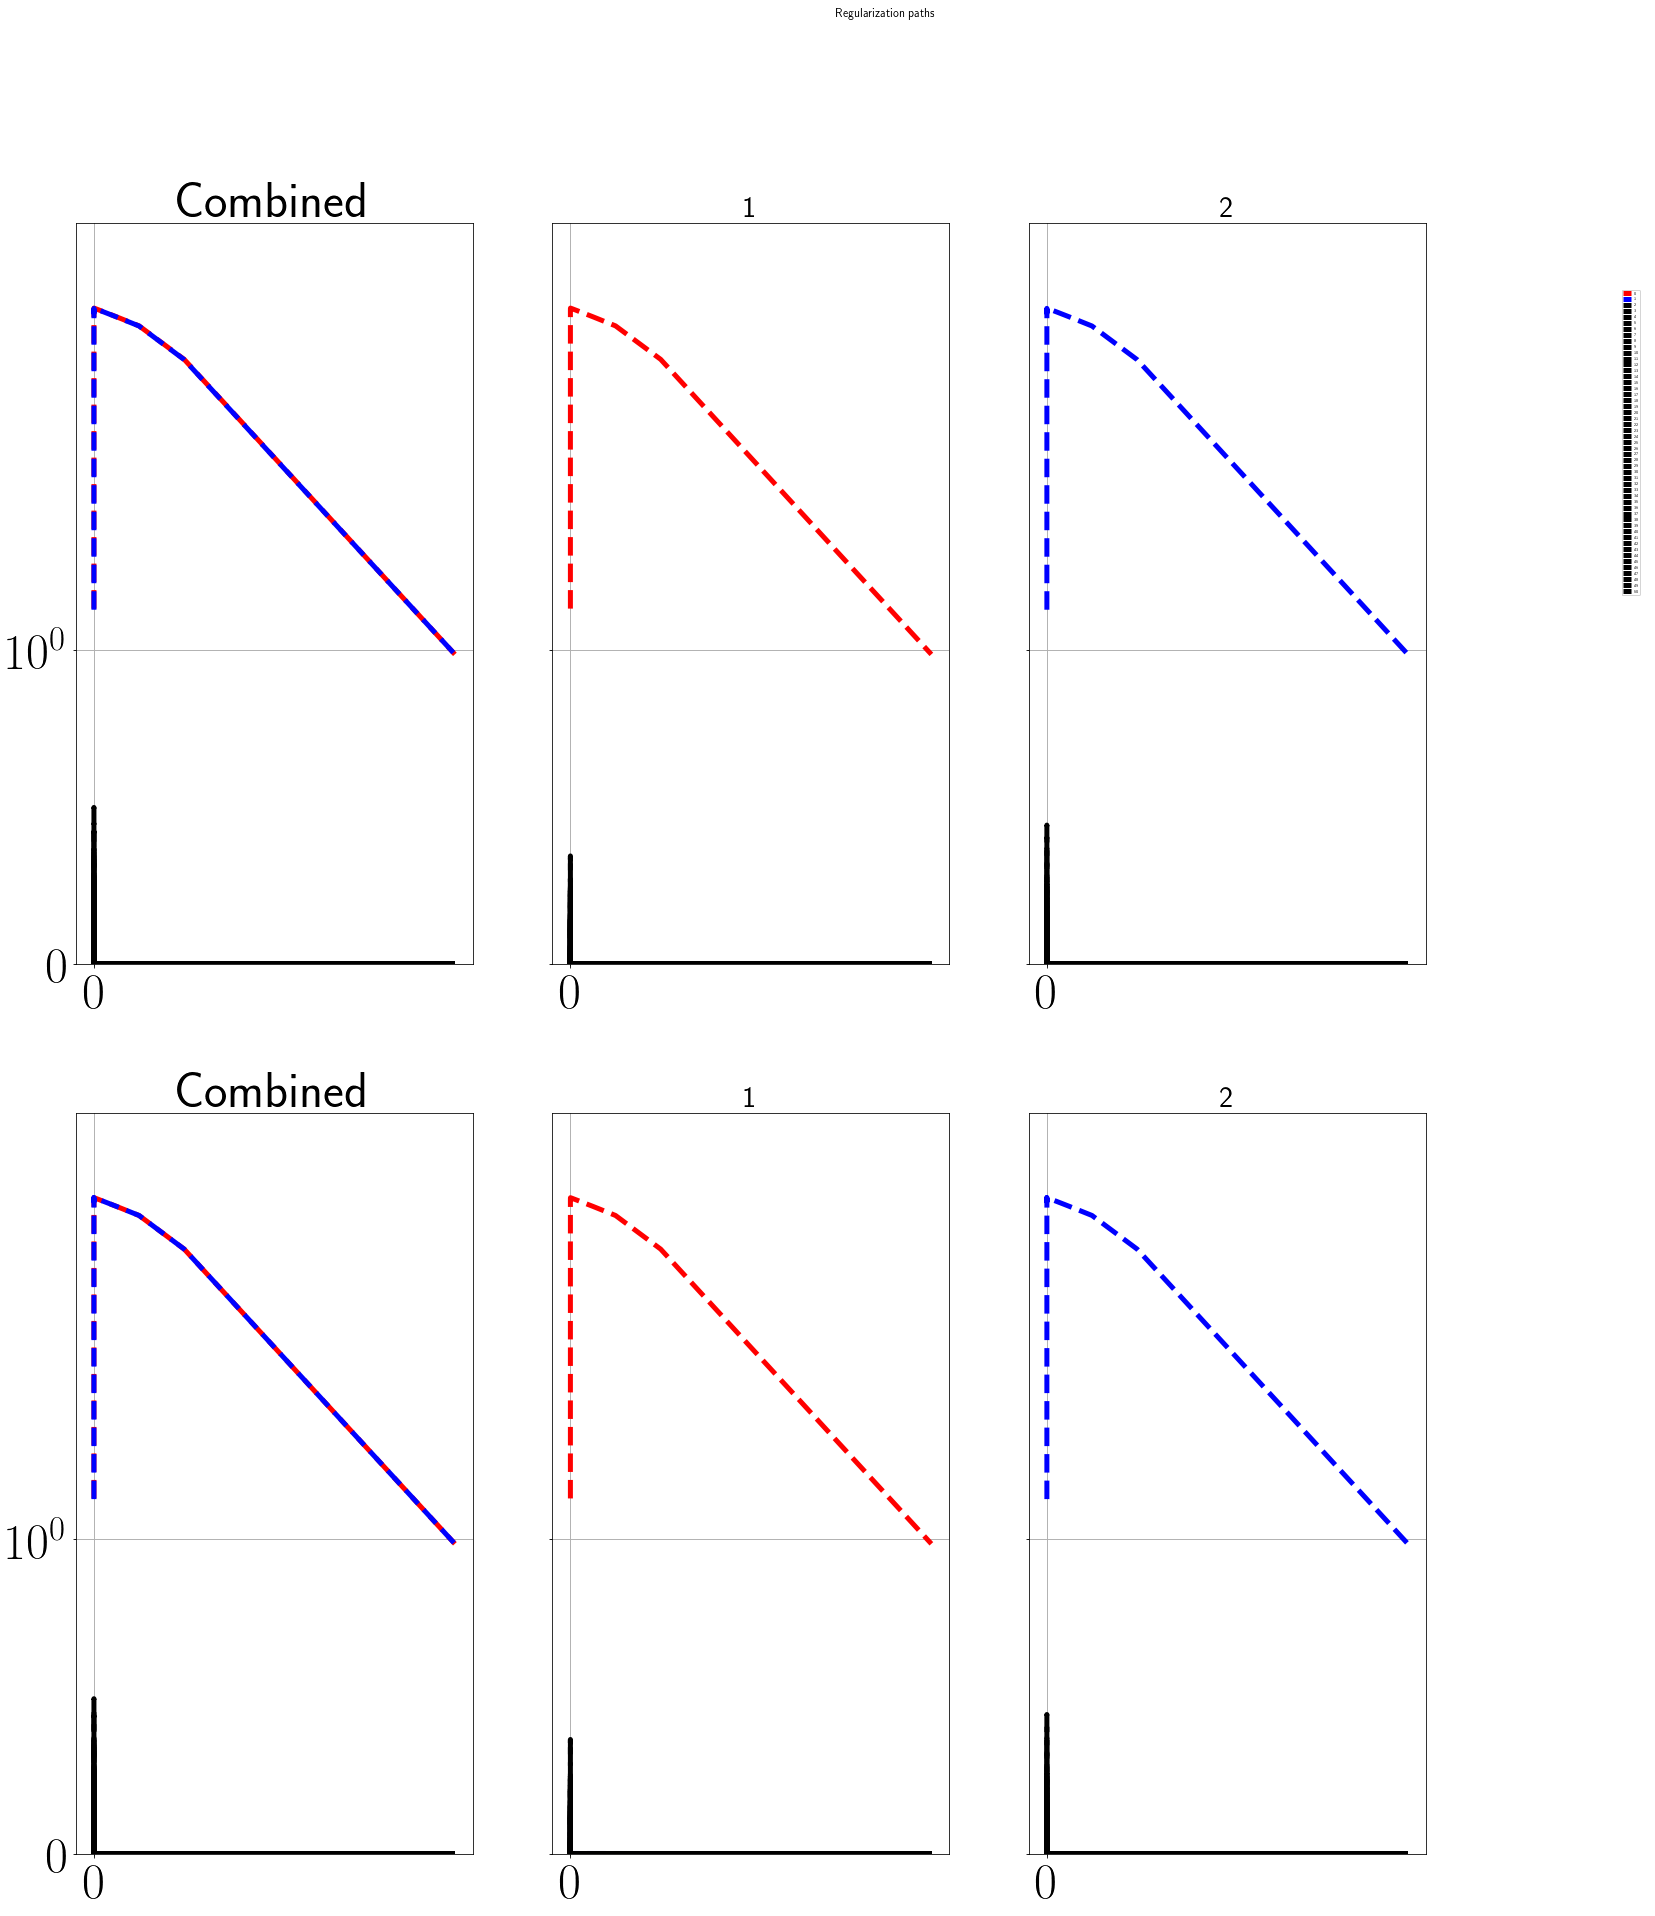

In [9]:
colors = np.hstack([np.repeat('red',1), np.repeat('blue',1),np.repeat('black',49)])

fig, axes_all = plt.subplots(nreps, m + 1,figsize=(15 * m, 15*nreps))
fig.suptitle('Regularization paths')
for i in range(nreps):
    replicates[i].coeffs, replicates[i].lambdas_plot = get_coeffs_and_lambdas(replicates[i].coeff_dict, replicates[i].lower_lambda, replicates[i].higher_lambda)
    plot_reg_path_ax_lambdasearch_customcolors(axes_all[i], replicates[i].coeffs, replicates[i].lambdas_plot * np.sqrt(m * nsel), fig,colors)
fig.savefig(folder + '/swiss_ltsa')
2+2

In [32]:
for i in range(nreps):
    replicates[i].coeffs, replicates[i].lambdas_plot = get_coeffs_and_lambdas(replicates[i].coeff_dict, replicates[i].lower_lambda, replicates[i].higher_lambda)


(24,)
(24,)


In [33]:
replicates_ltsa = copy.deepcopy(replicates)

In [11]:
N_isomap = RiemannianManifold(embed_isomap,2)
geom_isomap = experiment.M.geom
geom_isomap.rmetric = RiemannMetric(N_isomap.data,experiment.M.geom.laplacian_matrix,n_dim=d)
geom_isomap.rmetric.get_rmetric()
N_isomap.geom = geom_isomap

In [12]:
replicates = {}
for i in range(nreps):
    selected_points = selected_points_save[i]
    replicates[i] = Replicate()
    replicates[i].nsel = nsel
    replicates[i].selected_points = selected_points
    replicates[i].df_M,replicates[i].dg_M,replicates[i].dg_x ,replicates[i].dgx_norm  = get_grads_noshape_swiss(experiment, experiment.M, N_isomap, selected_points)
    replicates[i].xtrain, replicates[i].groups = experiment.construct_X_js(replicates[i].dg_M)
    replicates[i].ytrain = experiment.construct_Y_js(replicates[i].df_M,dimnoise)
    replicates[i].coeff_dict = {}
    replicates[i].coeff_dict[0] = experiment.get_betas_spam2(replicates[i].xtrain, replicates[i].ytrain, replicates[i].groups, np.asarray([0]), nsel, experiment.m, itermax, tol)
    replicates[i].combined_norms = {}
    replicates[i].combined_norms[0] = np.linalg.norm(np.linalg.norm(replicates[i].coeff_dict[0][:, :, :, :], axis=2), axis=1)[0,:]
    replicates[i].higher_lambda,replicates[i].coeff_dict,replicates[i].combined_norms = get_support_recovery_lambda(experiment, replicates[i],  lambda_max, max_search,dim)
    replicates[i].lower_lambda,replicates[i].coeff_dict,replicates[i].combined_norms = get_lower_interesting_lambda(experiment, replicates[i],  lambda_max, max_search)


0 1
1 0.5
2 0.25
we did it
0 1
1 0.5
2 0.25
3 0.125
4 0.0625
5 0.03125
6 0.015625
7 0.0078125
8 0.00390625
9 0.001953125
10 0.0009765625
11 0.00048828125
12 0.000244140625
13 0.0001220703125
14 6.103515625e-05
15 3.0517578125e-05
16 1.52587890625e-05
17 7.62939453125e-06
18 3.814697265625e-06
19 1.9073486328125e-06
20 9.5367431640625e-07
21 4.76837158203125e-07
22 2.384185791015625e-07
23 1.1920928955078125e-07
24 5.960464477539063e-08
25 2.9802322387695312e-08
we did it
0 1
1 0.5
2 0.25
we did it
0 1
1 0.5
2 0.25
3 0.125
4 0.0625
5 0.03125
6 0.015625
7 0.0078125
8 0.00390625
9 0.001953125
10 0.0009765625
11 0.00048828125
12 0.000244140625
13 0.0001220703125
14 6.103515625e-05
15 3.0517578125e-05
16 1.52587890625e-05
17 7.62939453125e-06
18 3.814697265625e-06
19 1.9073486328125e-06
20 9.5367431640625e-07
21 4.76837158203125e-07
22 2.384185791015625e-07
23 1.1920928955078125e-07
24 5.960464477539063e-08
25 2.9802322387695312e-08
we did it


(24,)
(24,)


/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


4

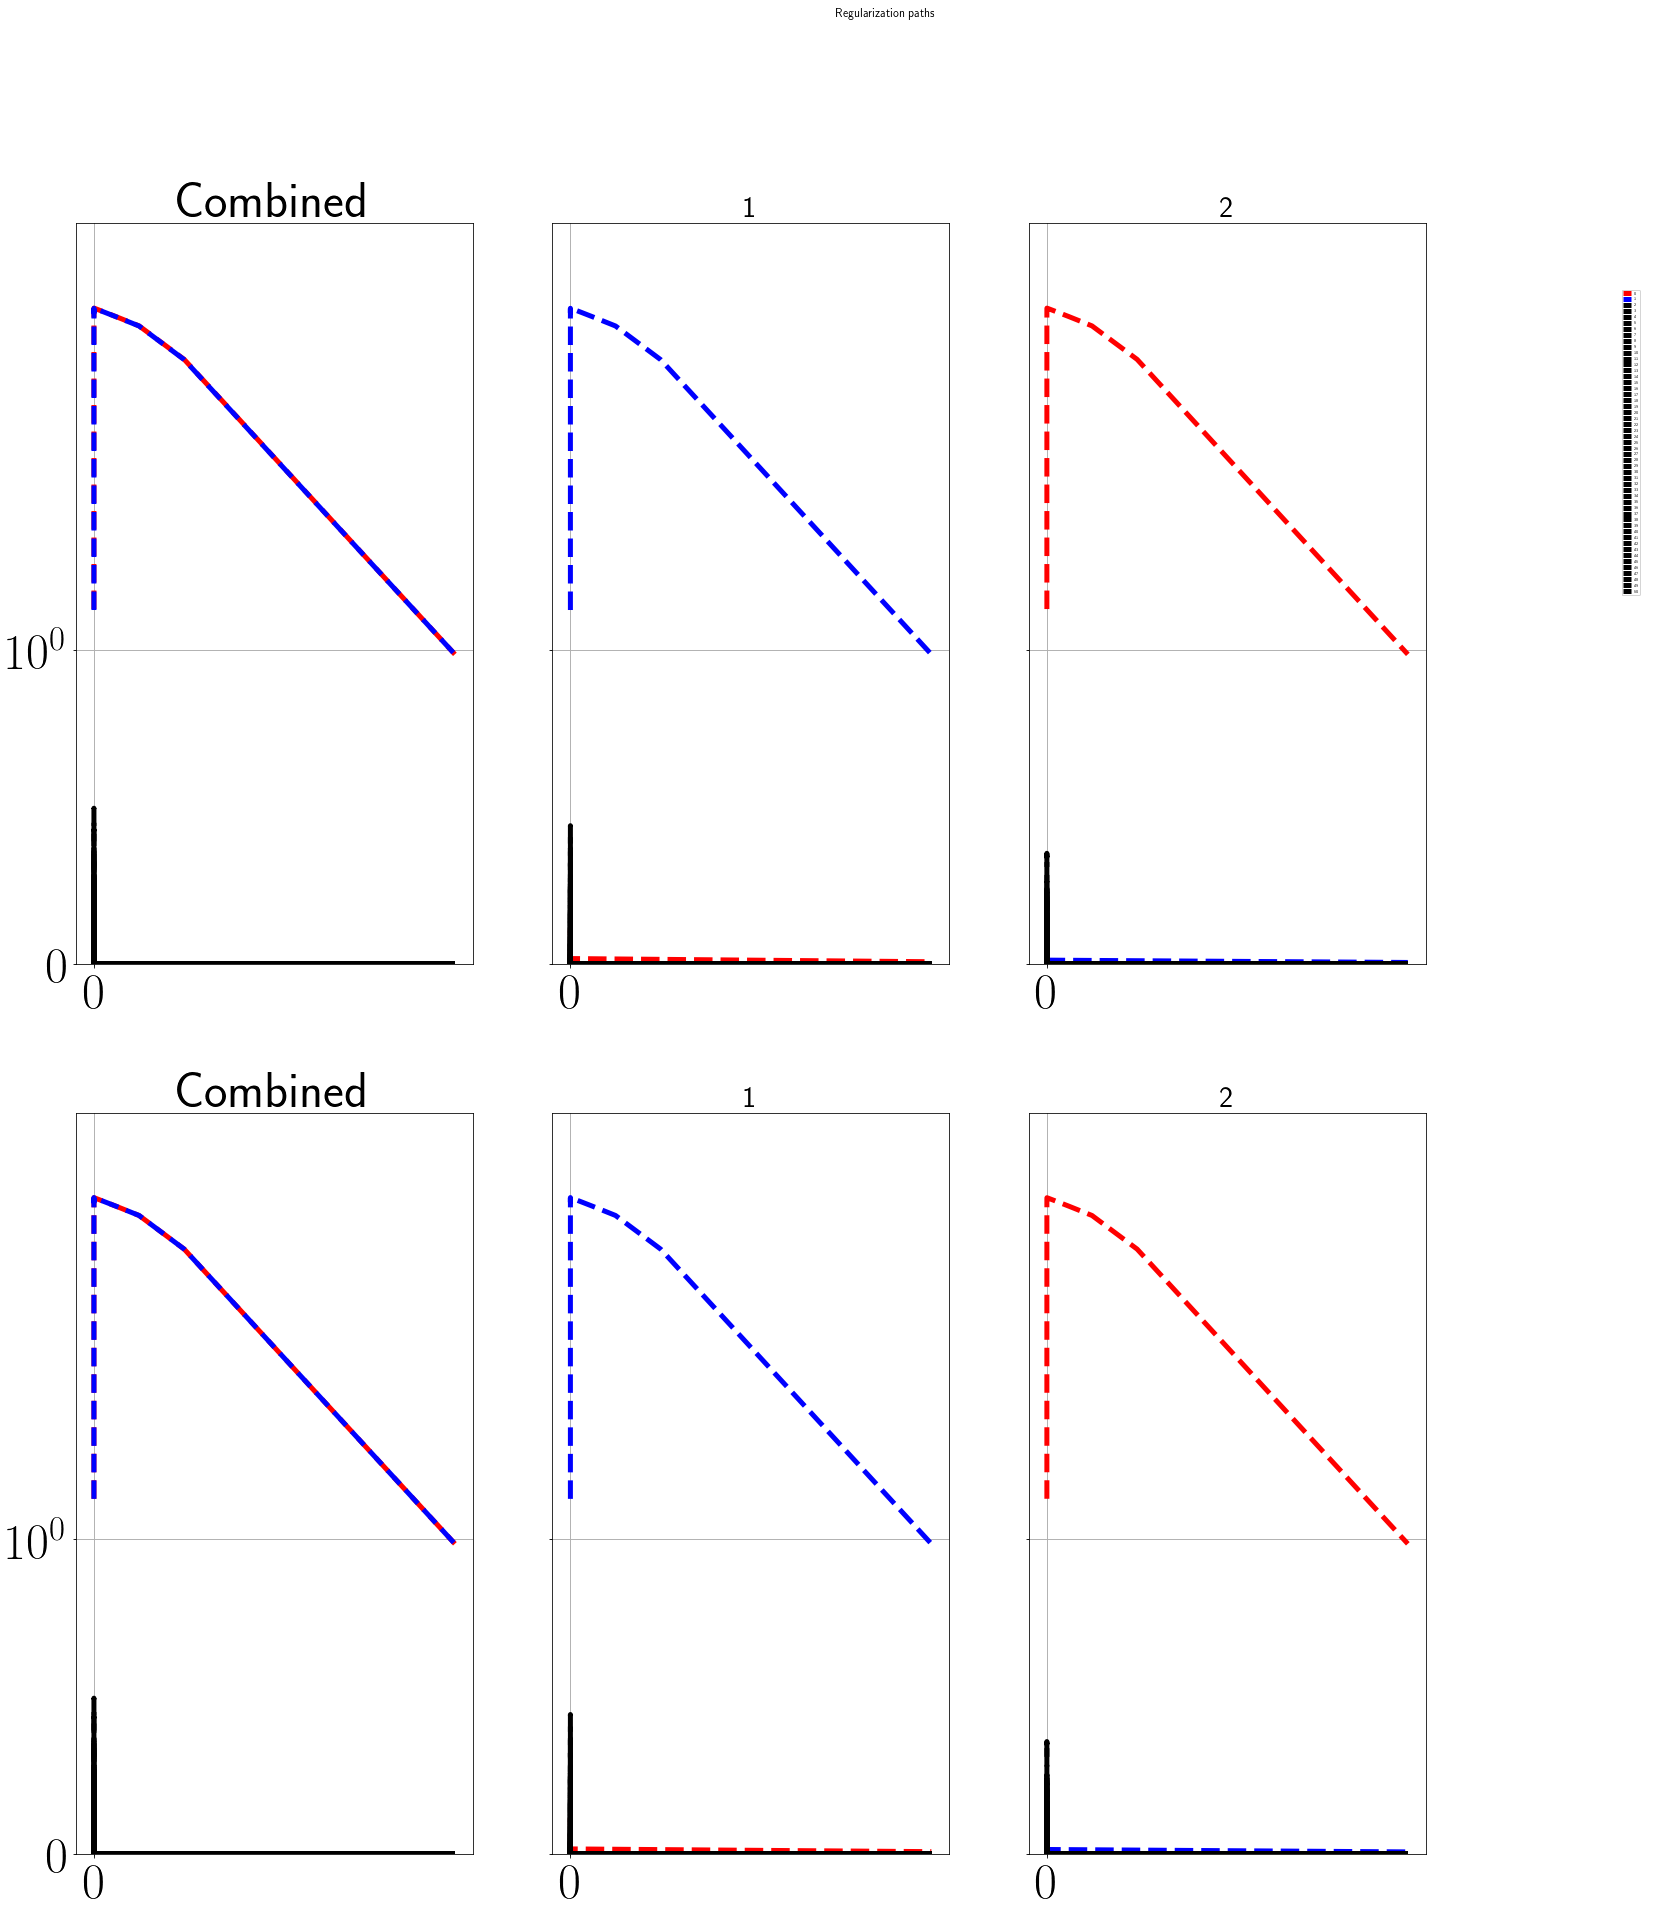

In [13]:
colors = np.hstack([np.repeat('red',1), np.repeat('blue',1),np.repeat('black',49)])

fig, axes_all = plt.subplots(nreps, m + 1,figsize=(15 * m, 15*nreps))
fig.suptitle('Regularization paths')
for i in range(nreps):
    replicates[i].coeffs, replicates[i].lambdas_plot = get_coeffs_and_lambdas(replicates[i].coeff_dict, replicates[i].lower_lambda, replicates[i].higher_lambda)
    plot_reg_path_ax_lambdasearch_customcolors(axes_all[i], replicates[i].coeffs, replicates[i].lambdas_plot * np.sqrt(m * nsel), fig,colors)
fig.savefig(folder + '/swiss_isomap')
2+2

In [14]:
replicates_isomap = copy.deepcopy(replicates)

In [15]:
N_spectral = experiment.N
geom_spectral = experiment.M.geom
geom_spectral.rmetric = RiemannMetric(N_spectral.data,experiment.M.geom.laplacian_matrix,n_dim=d)
geom_spectral.rmetric.get_rmetric()
N_spectral.geom = geom_spectral

In [16]:
replicates = {}
for i in range(nreps):
    selected_points = selected_points_save[i]
    replicates[i] = Replicate()
    replicates[i].nsel = nsel
    replicates[i].selected_points = selected_points
    replicates[i].df_M,replicates[i].dg_M,replicates[i].dg_x ,replicates[i].dgx_norm  = get_grads_noshape_swiss(experiment, experiment.M, N_spectral, selected_points)
    replicates[i].xtrain, replicates[i].groups = experiment.construct_X_js(replicates[i].dg_M)
    replicates[i].ytrain = experiment.construct_Y_js(replicates[i].df_M,dimnoise)
    replicates[i].coeff_dict = {}
    replicates[i].coeff_dict[0] = experiment.get_betas_spam2(replicates[i].xtrain, replicates[i].ytrain, replicates[i].groups, np.asarray([0]), nsel, experiment.m, itermax, tol)
    replicates[i].combined_norms = {}
    replicates[i].combined_norms[0] = np.linalg.norm(np.linalg.norm(replicates[i].coeff_dict[0][:, :, :, :], axis=2), axis=1)[0,:]
    replicates[i].higher_lambda,replicates[i].coeff_dict,replicates[i].combined_norms = get_support_recovery_lambda(experiment, replicates[i],  lambda_max, max_search,dim)
    replicates[i].lower_lambda,replicates[i].coeff_dict,replicates[i].combined_norms = get_lower_interesting_lambda(experiment, replicates[i],  lambda_max, max_search)


0 1
1 0.5
2 0.25
we did it
0 1
1 0.5
2 0.25
3 0.125
4 0.0625
5 0.03125
6 0.015625
7 0.0078125
8 0.00390625
9 0.001953125
10 0.0009765625
11 0.00048828125
12 0.000244140625
13 0.0001220703125
14 6.103515625e-05
15 3.0517578125e-05
16 1.52587890625e-05
17 7.62939453125e-06
18 3.814697265625e-06
19 1.9073486328125e-06
20 9.5367431640625e-07
21 4.76837158203125e-07
22 2.384185791015625e-07
23 1.1920928955078125e-07
24 5.960464477539063e-08
25 2.9802322387695312e-08
26 1.4901161193847656e-08
we did it
0 1
1 0.5
2 0.25
we did it
0 1
1 0.5
2 0.25
3 0.125
4 0.0625
5 0.03125
6 0.015625
7 0.0078125
8 0.00390625
9 0.001953125
10 0.0009765625
11 0.00048828125
12 0.000244140625
13 0.0001220703125
14 6.103515625e-05
15 3.0517578125e-05
16 1.52587890625e-05
17 7.62939453125e-06
18 3.814697265625e-06
19 1.9073486328125e-06
20 9.5367431640625e-07
21 4.76837158203125e-07
22 2.384185791015625e-07
23 1.1920928955078125e-07
24 5.960464477539063e-08
25 2.9802322387695312e-08
we did it


(25,)
(24,)


/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


4

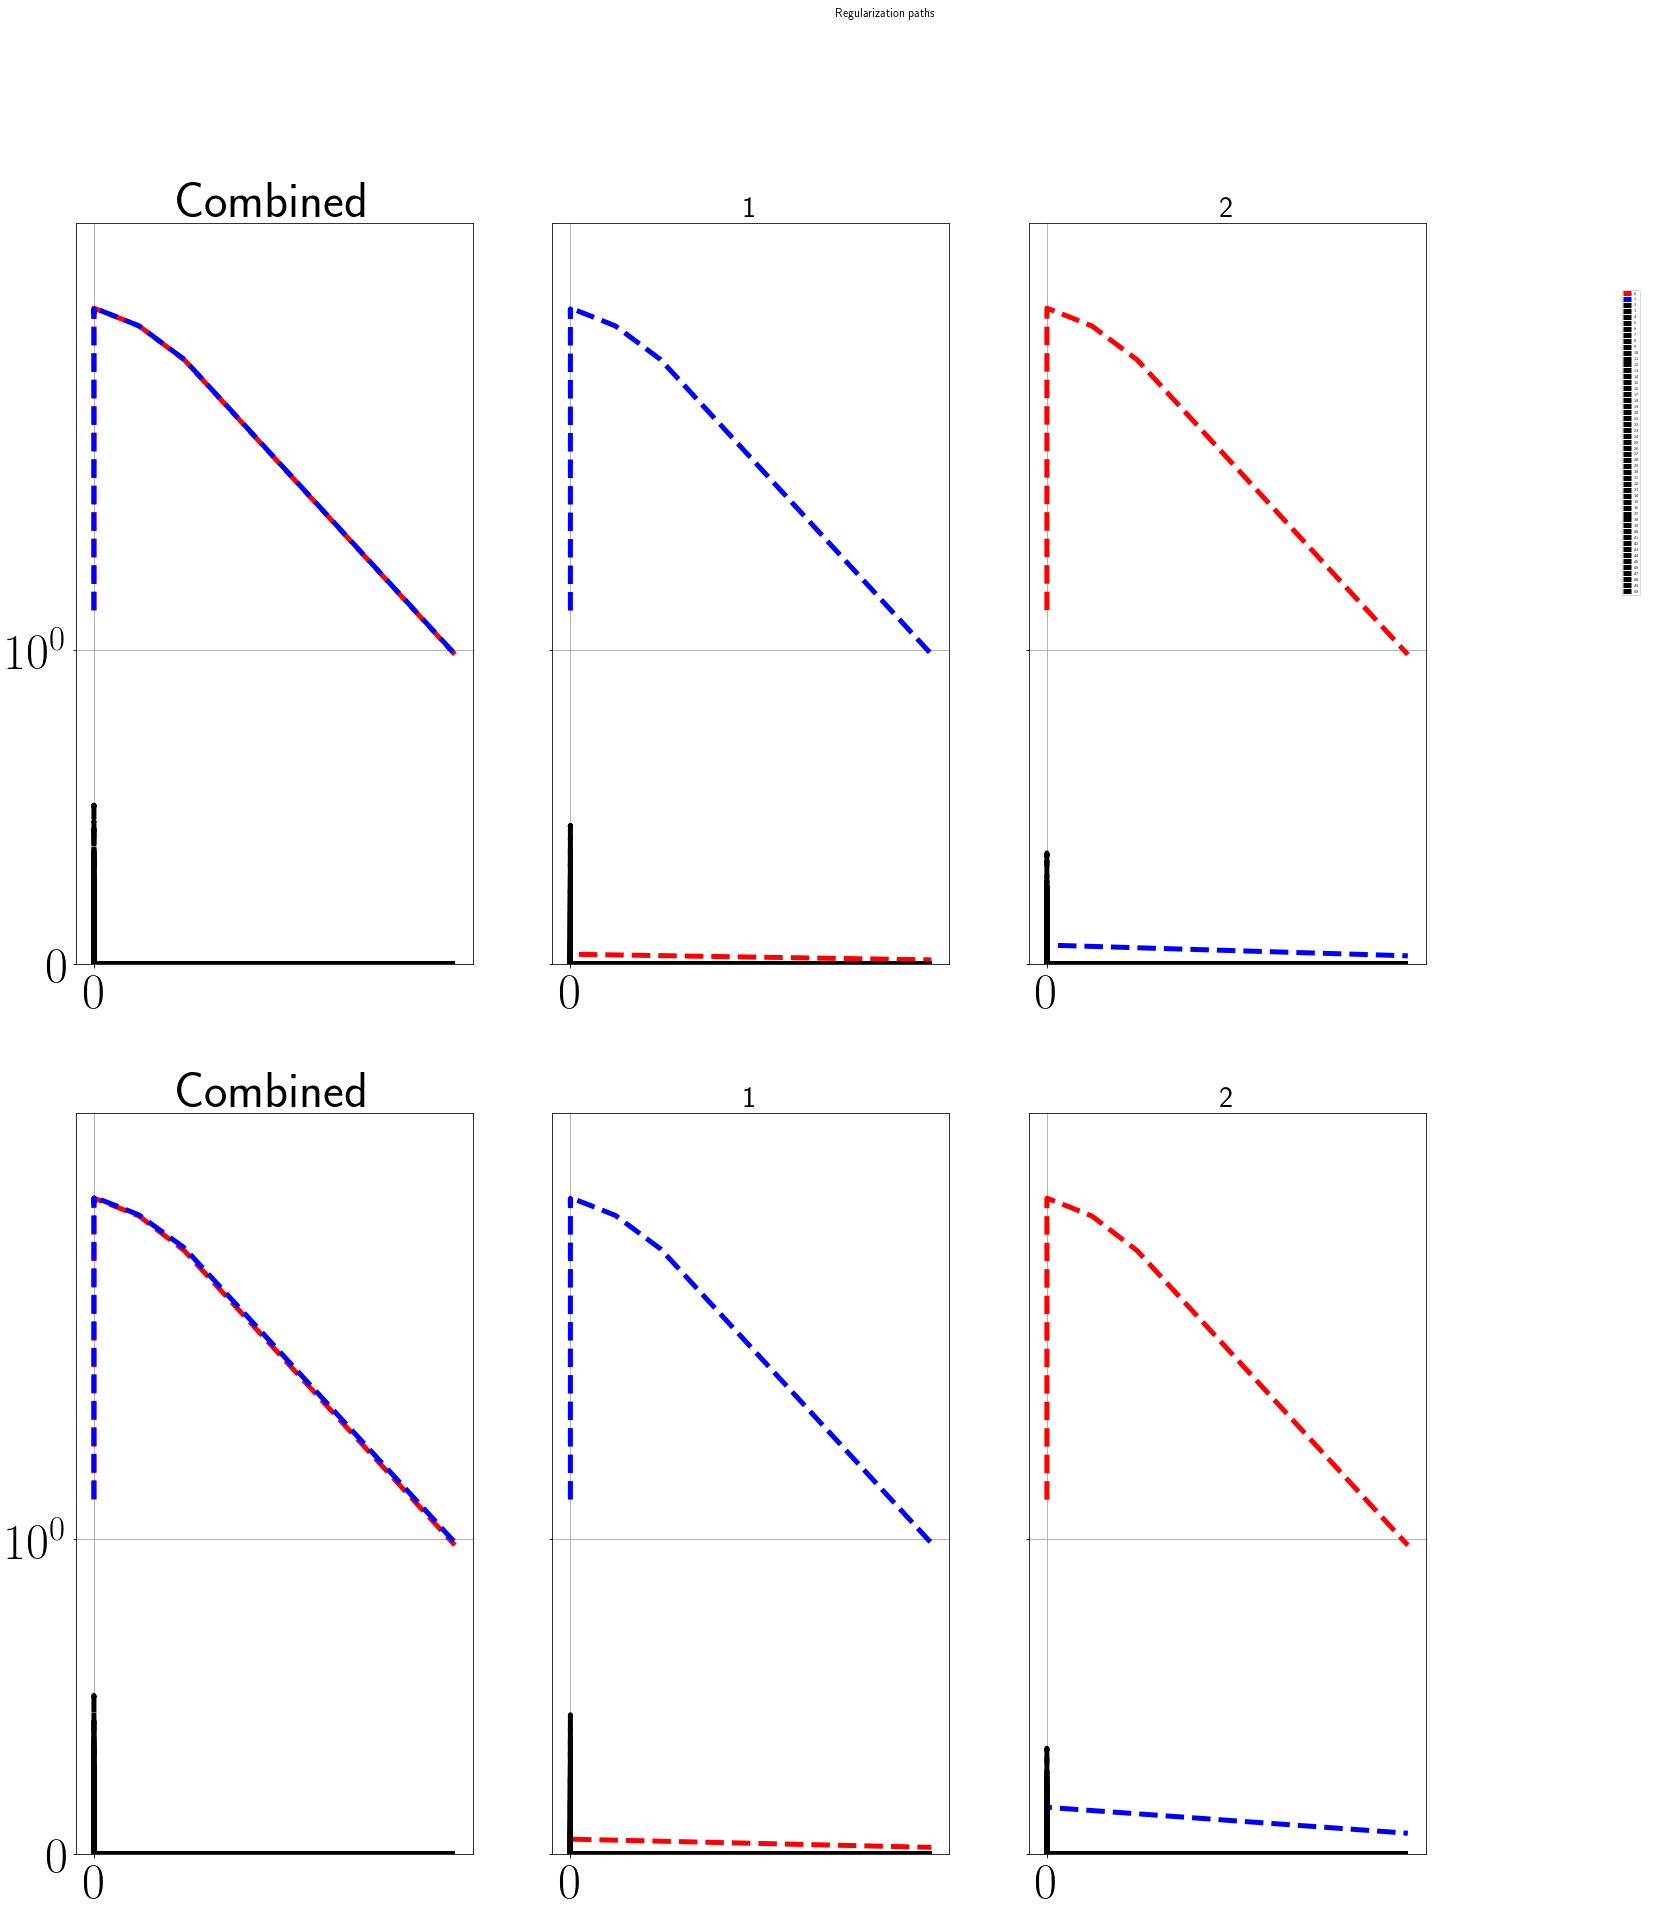

In [17]:
colors = np.hstack([np.repeat('red',1), np.repeat('blue',1),np.repeat('black',49)])

fig, axes_all = plt.subplots(nreps, m + 1,figsize=(15 * m, 15*nreps))
fig.suptitle('Regularization paths')
for i in range(nreps):
    replicates[i].coeffs, replicates[i].lambdas_plot = get_coeffs_and_lambdas(replicates[i].coeff_dict, replicates[i].lower_lambda, replicates[i].higher_lambda)
    plot_reg_path_ax_lambdasearch_customcolors(axes_all[i], replicates[i].coeffs, replicates[i].lambdas_plot * np.sqrt(m * nsel), fig,colors)
fig.savefig(folder + '/swiss_spectral')
2+2

In [18]:
replicates_spectral = copy.deepcopy(replicates)

In [34]:
with open('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/swiss_internal.pkl' ,
        'wb') as output:
    pickle.dump(replicates_internal, output, pickle.HIGHEST_PROTOCOL)

with open('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/swiss_isomap.pkl' ,
        'wb') as output:
    pickle.dump(replicates_isomap, output, pickle.HIGHEST_PROTOCOL)

with open('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/swiss_ltsa.pkl' ,
        'wb') as output:
    pickle.dump(replicates_ltsa, output, pickle.HIGHEST_PROTOCOL)

with open('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/swiss_spectral.pkl' ,
        'wb') as output:
    pickle.dump(replicates_spectral, output, pickle.HIGHEST_PROTOCOL)

#     replicates_spectral
    
#     replicates_ltso
    
#     replicates_isomap

In [31]:
replicates_ltsa[0].coeffs

AttributeError: 'Replicate' object has no attribute 'coeffs'

In [22]:
#embed_isomap

np.save('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/swiss_internal',N_internal.data)

np.save('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/swiss_spectral', N_spectral.data)
np.save('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/swiss_isomap',
       N_isomap.data)

np.save('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/swiss_ltsa',
       N_ltsa.data)


In [24]:
#help(np.save)

In [ ]:
np.save('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/swiss_ltsa',
       N_ltsa.data)

In [28]:

with open('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/swiss_ltsa.pkl' ,
        'wb') as output:
    pickle.dump(replicates_ltsa, output, pickle.HIGHEST_PROTOCOL)
